# Construisez un modèle de scoring

## Introduction

<div>
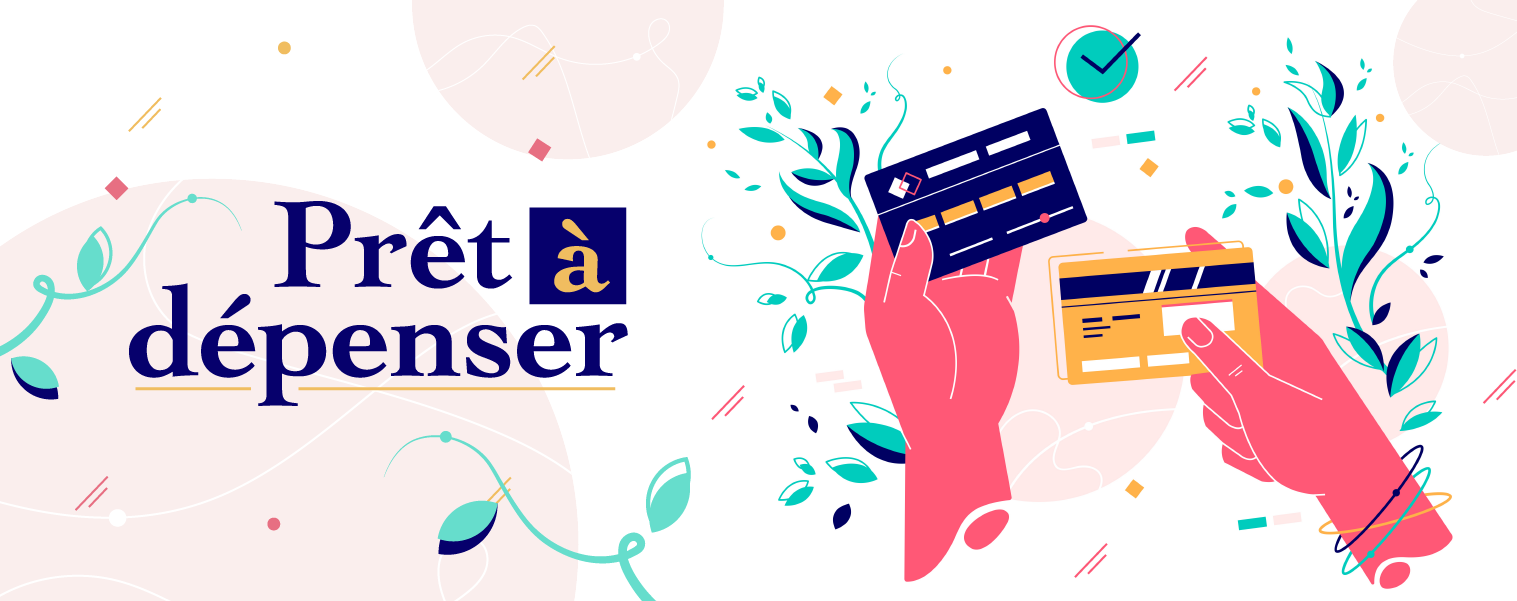
</div>

**Mon rôle:** Data Scientist  
**Nom de la société**: Prêt à dépenser  
**Service de la société**: Propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

**Mission**: Aider à décider si un prêt peut être accordé à un client.  
Mettre en œuvre un algorithme de classification de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non.  
Puis classifie la demande : crédit accordé ou refusé.

**Utilisateurs**: Chargés de relation client.

**Remarques**: Le modèle doit être facilement interprétable et doit disposer d’une mesure de l’importance des variables pour définir la probabilité.

---

**Fichiers d'entrée**:
- [10 fichiers CSV](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)
- [Explication de chaque fichier](https://www.kaggle.com/c/home-credit-default-risk/data)
- Description des colonnes: Voir le fichier: [HomeCredit_columns_description.csv](../input/HomeCredit_columns_description.csv)

## Importation des différents fichiers

In [52]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
os.listdir("../input/")

['application_test.csv',
 '.DS_Store',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 '.ipynb_checkpoints',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [53]:
# Removing unethical columns to remove bias
unethical_columns = [
    "CODE_GENDER",
    "DAYS_BIRTH",
]

## Analyse exploratoire

In [54]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [55]:
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

In [56]:
def create_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Manquant: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()



In [57]:
missing_columns = app_train.columns[app_train.isnull().any()].tolist()

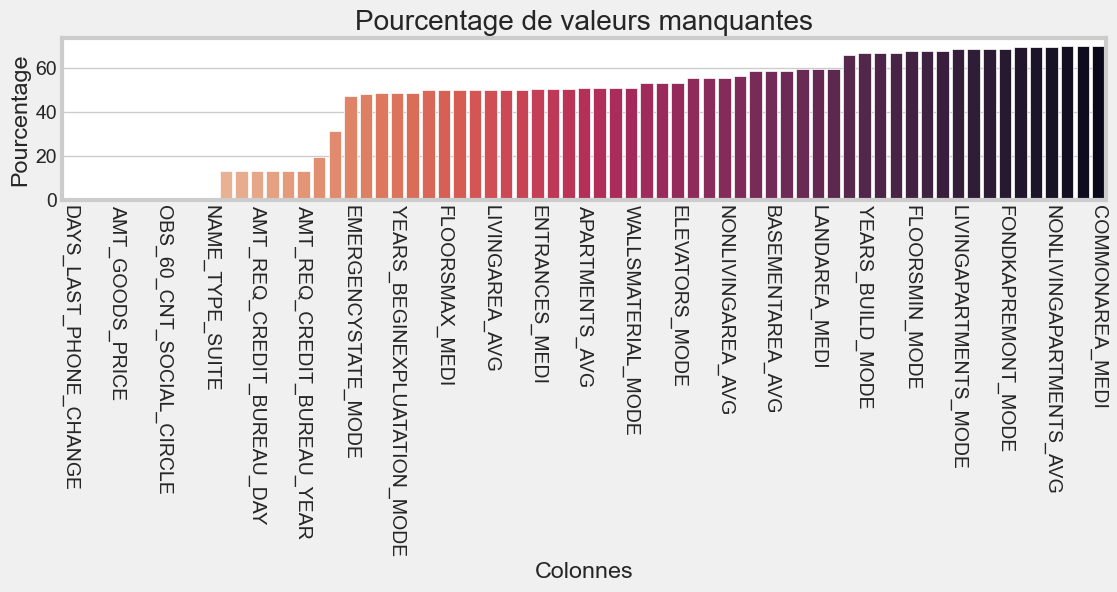

In [58]:
create_percentage_missing_chart(app_train[missing_columns], 3)

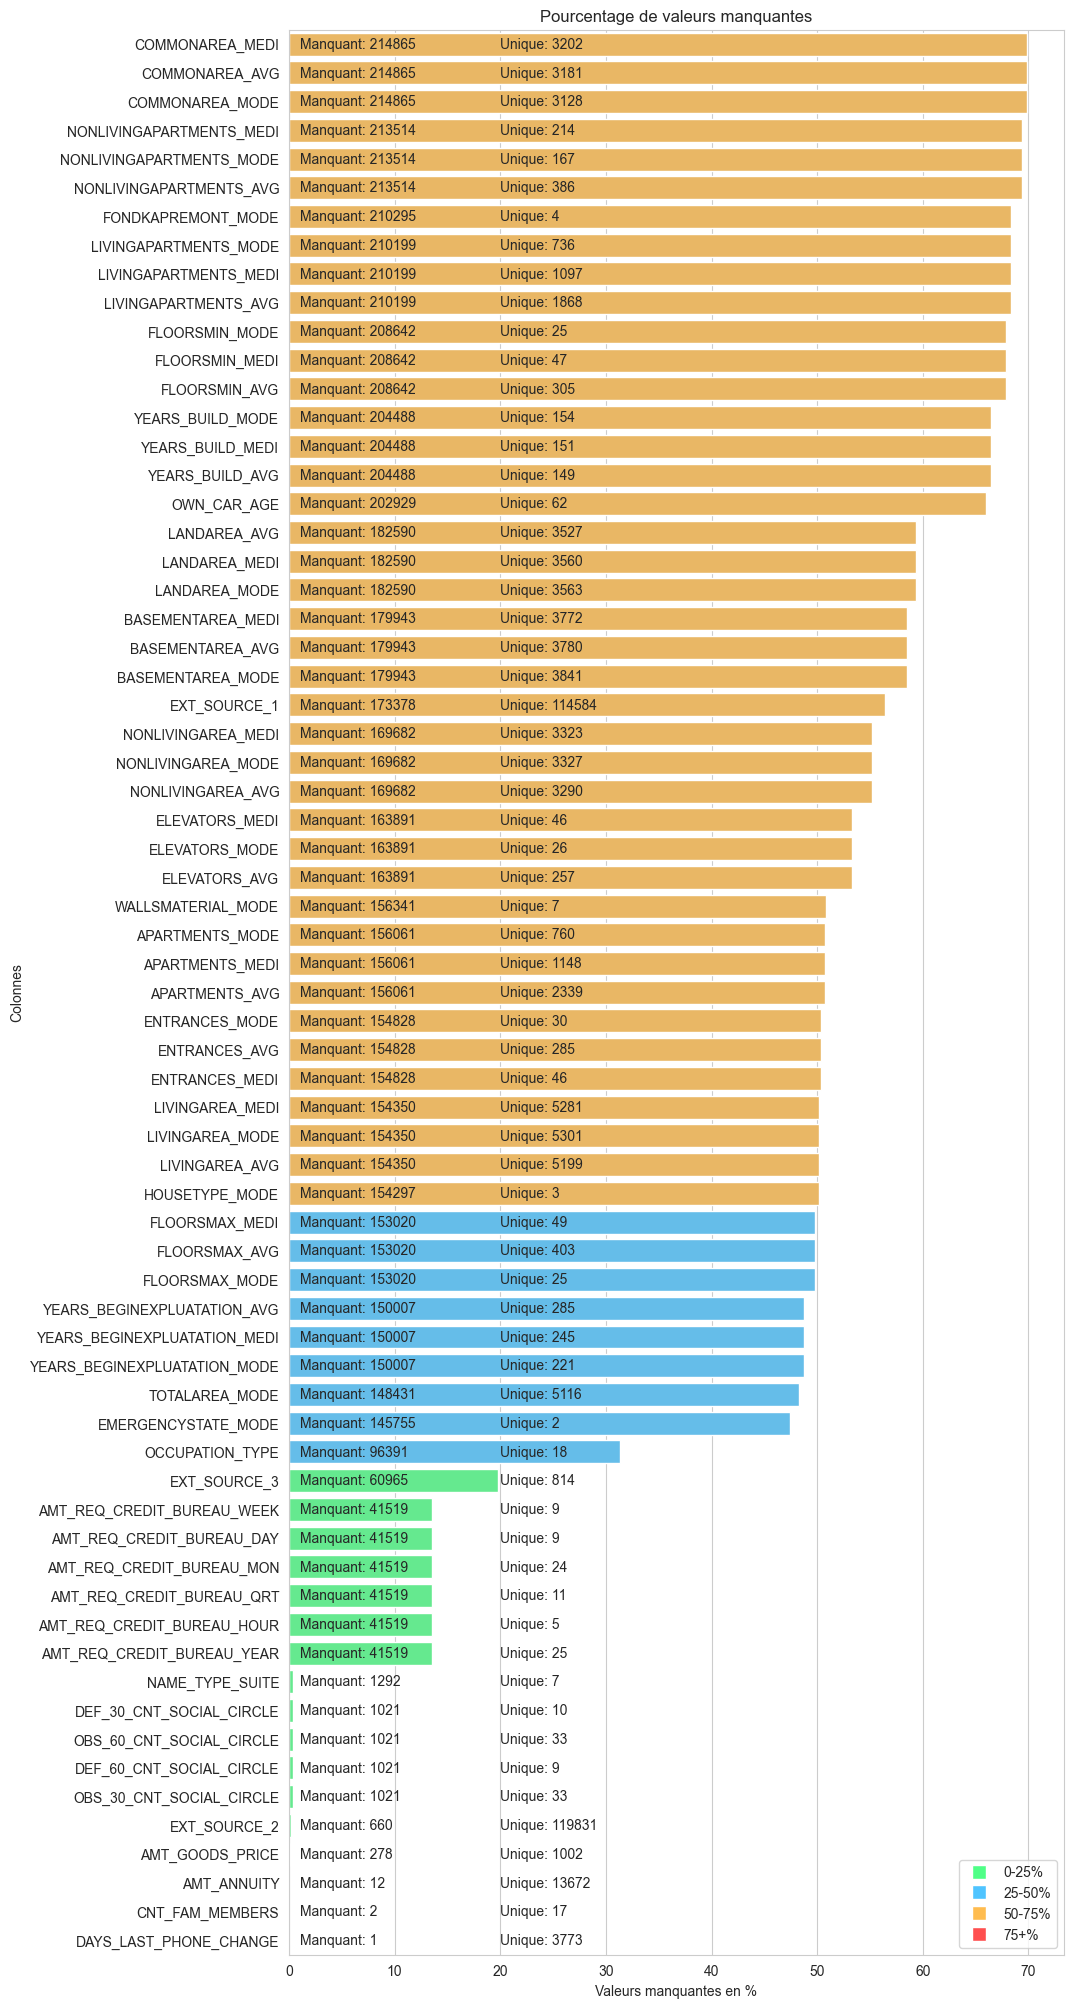

In [7]:
display_graph_missing_data(app_train[missing_columns], 25)

In [59]:
app_train.dtypes.value_counts()

float64    65
int64      40
object     15
Name: count, dtype: int64

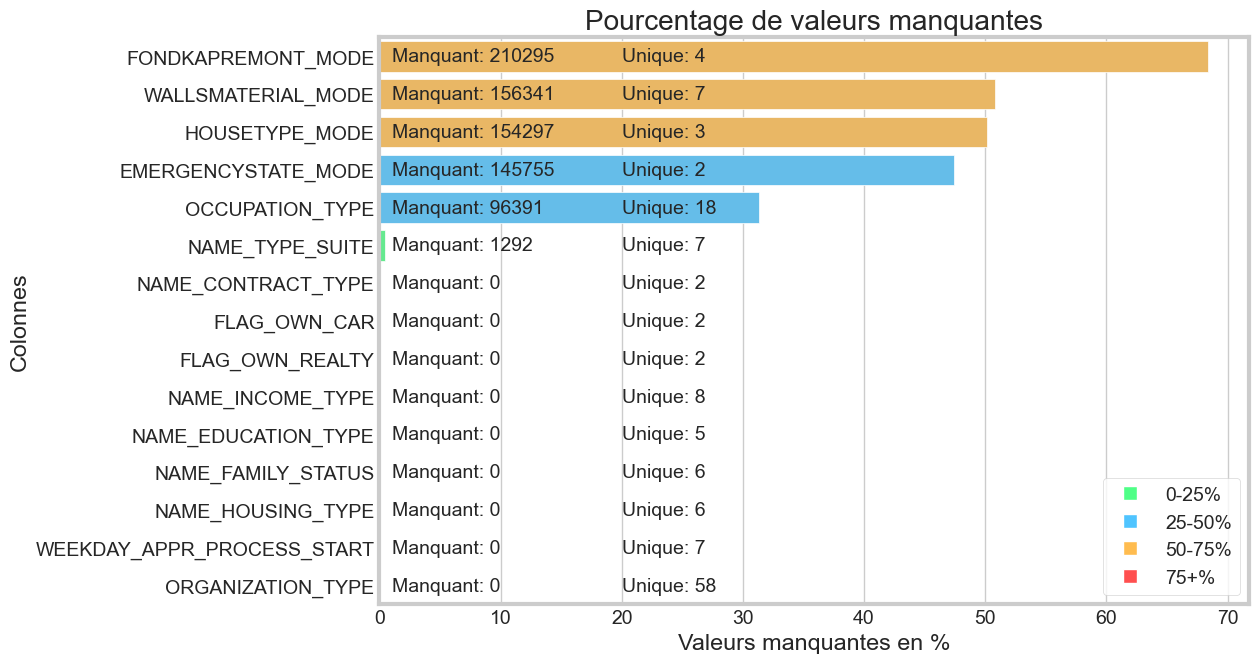

In [60]:
display_graph_missing_data(app_train.select_dtypes('object'), 7)

In [61]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


In [62]:
print('Training Features shape before: ', app_train.shape)
print('Testing Features shape before: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\nTraining Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape before:  (307511, 120)
Testing Features shape before:  (48744, 119)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 236)


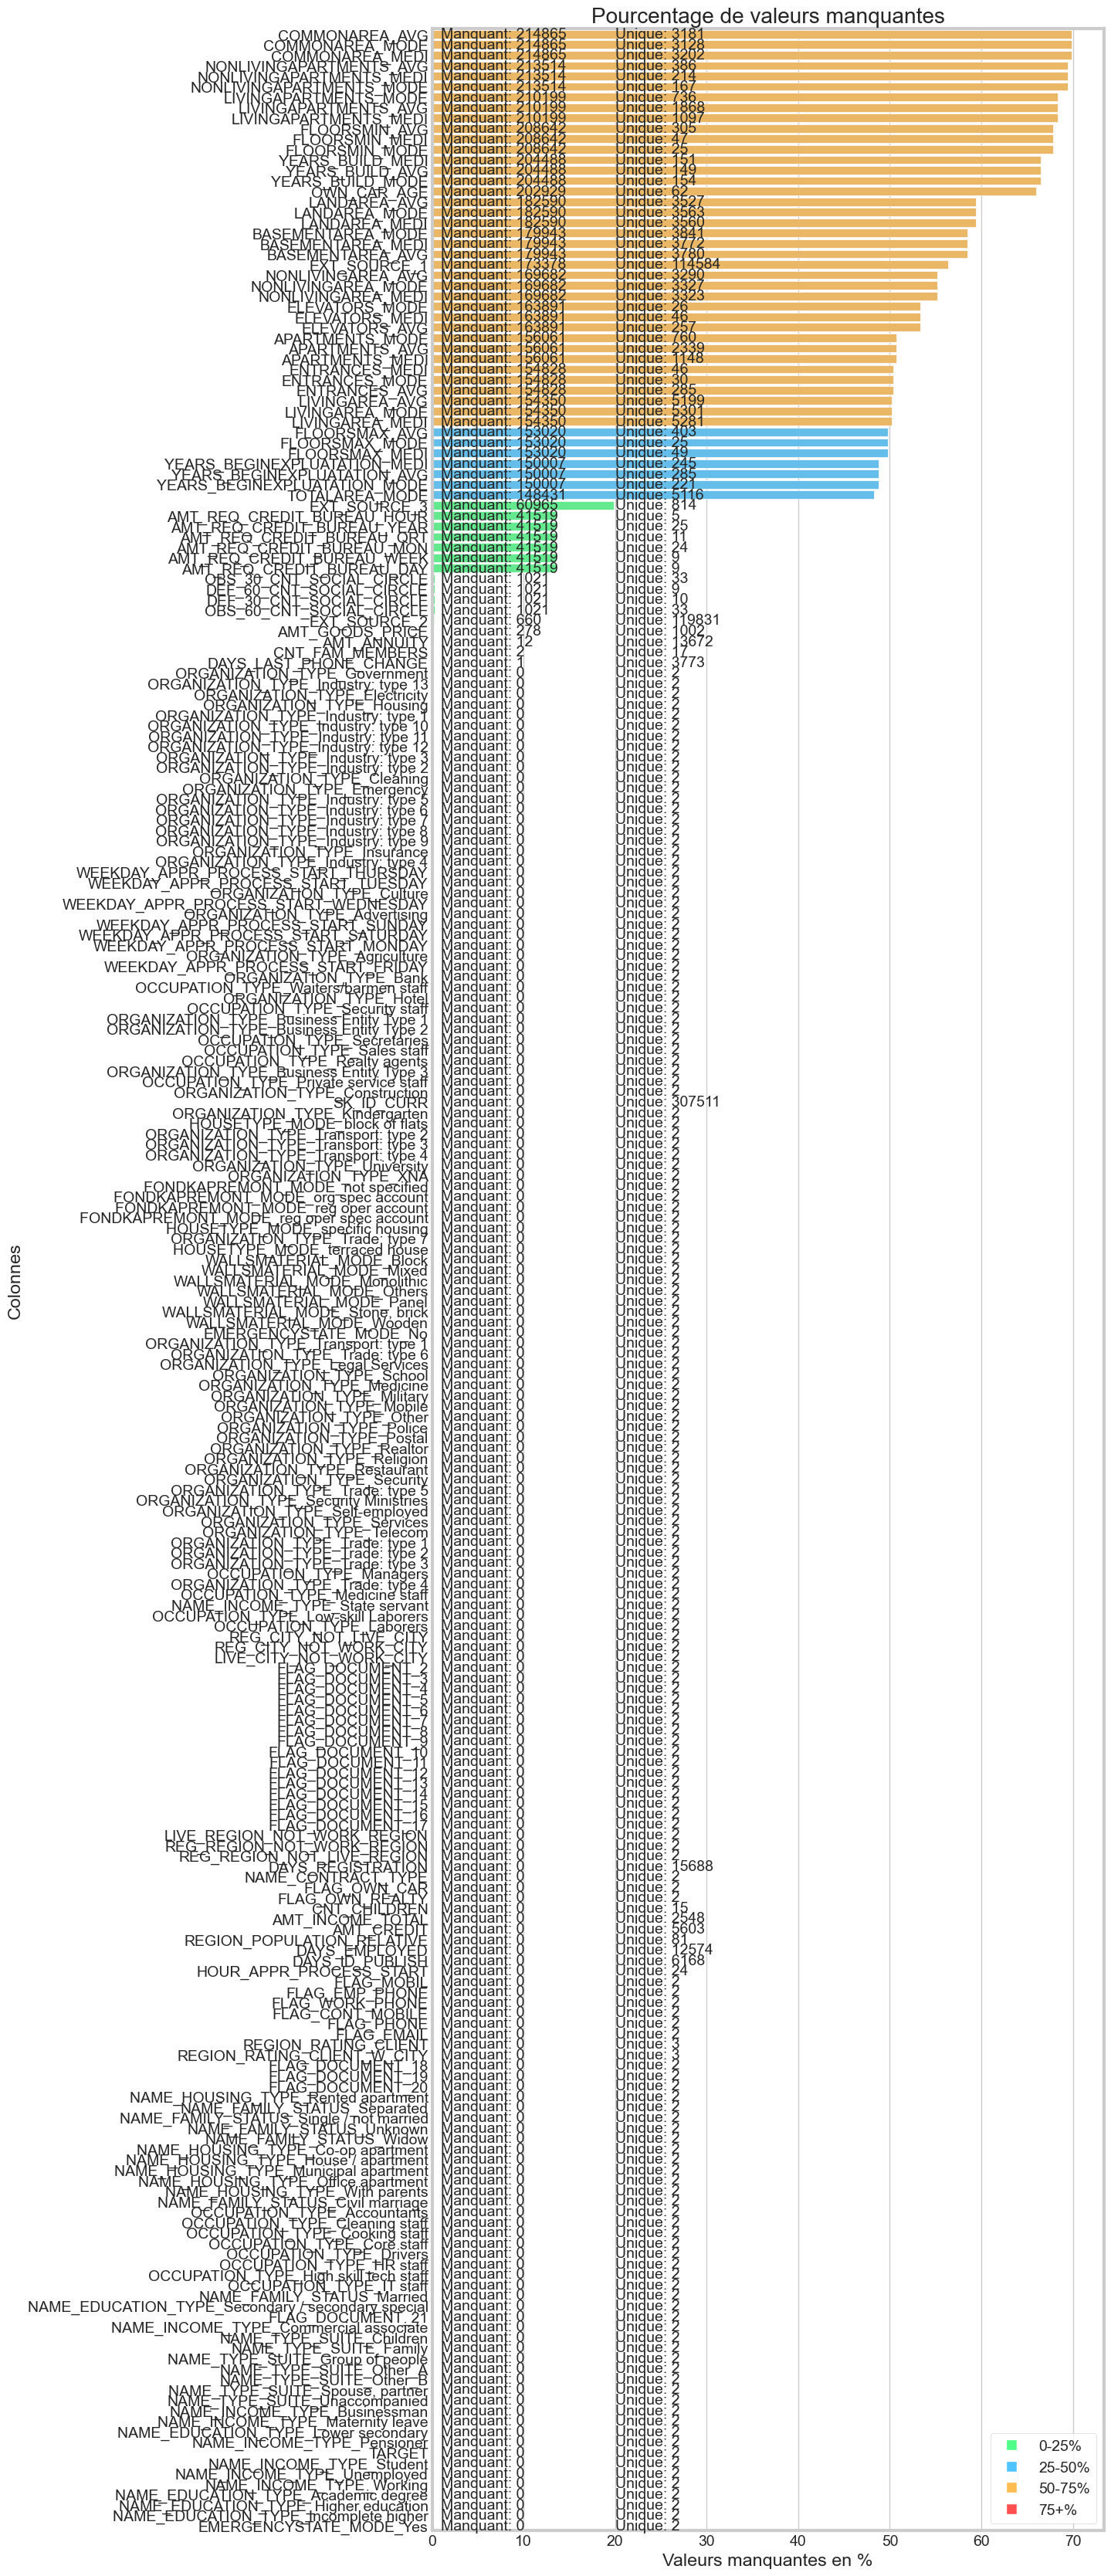

In [63]:
display_graph_missing_data(abspp_train, 40)

In [65]:
# app_train['DAYS_BIRTH'].describe()
# (app_train['DAYS_BIRTH'] / 365).describe()

In [66]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
#  is about 1000 years!

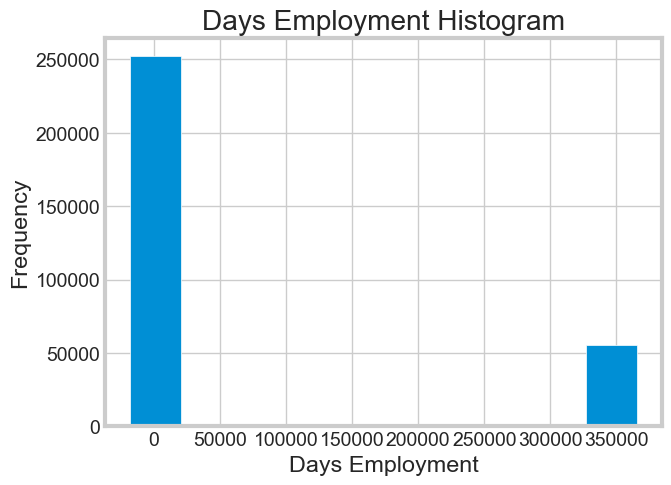

In [67]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [69]:
app_train['DAYS_EMPLOYED']

0           -637
1          -1188
2           -225
3          -3039
4          -3038
           ...  
307506      -236
307507    365243
307508     -7921
307509     -4786
307510     -1262
Name: DAYS_EMPLOYED, Length: 307511, dtype: int64

In [70]:
 app_train[app_train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

DAYS_EMPLOYED
365243    55374
Name: count, dtype: int64

In [72]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

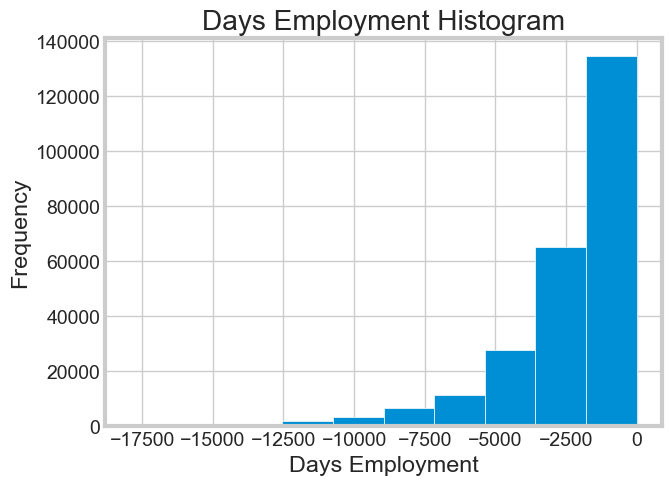

In [73]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [23]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [24]:
# TODO >
# Features importances global
# Entraine un random forest avec toutes les cases, c'est mieux de les normaliser
# Excplication métier > Gain de temps en rendez-vous car moins de features.

In [82]:
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])
app_train['DAYS_EMPLOYED'].corr(app_train['TARGET'])

-0.07495845742543839

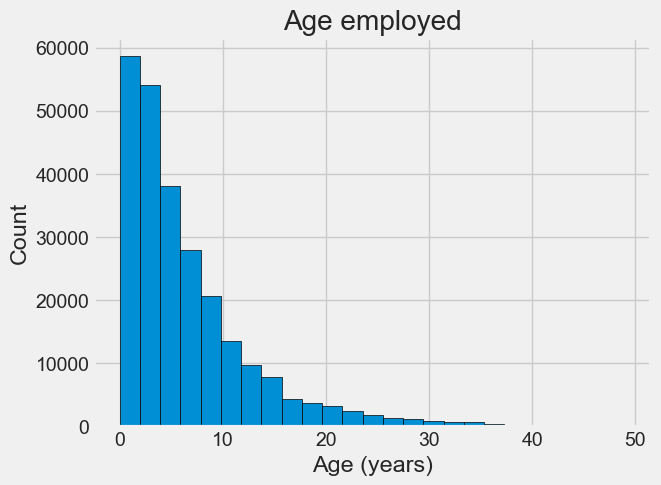

In [83]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
# plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
# plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

# Plot the distribution of ages in years
plt.hist(abs(app_train['DAYS_EMPLOYED']) / 365, edgecolor = 'k', bins = 25)
plt.title('Age employed'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [84]:
# Check outliers of all other columns
# Box plot of all columns

In [85]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_EMPLOYED']].copy()  
age_data.loc[:, 'YEARS_EMPLOYED'] = abs(age_data['DAYS_EMPLOYED']) / 365

# # Bin the age data

# age_data.loc[:, 'YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_EMPLOYED  YEARS_EMPLOYED
0       1          637.0        1.745205
1       0         1188.0        3.254795
2       0          225.0        0.616438
3       0         3039.0        8.326027
4       0         3038.0        8.323288
5       0         1588.0        4.350685
6       0         3130.0        8.575342
7       0          449.0        1.230137
8       0            NaN             NaN
9       0         2019.0        5.531507

In [34]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

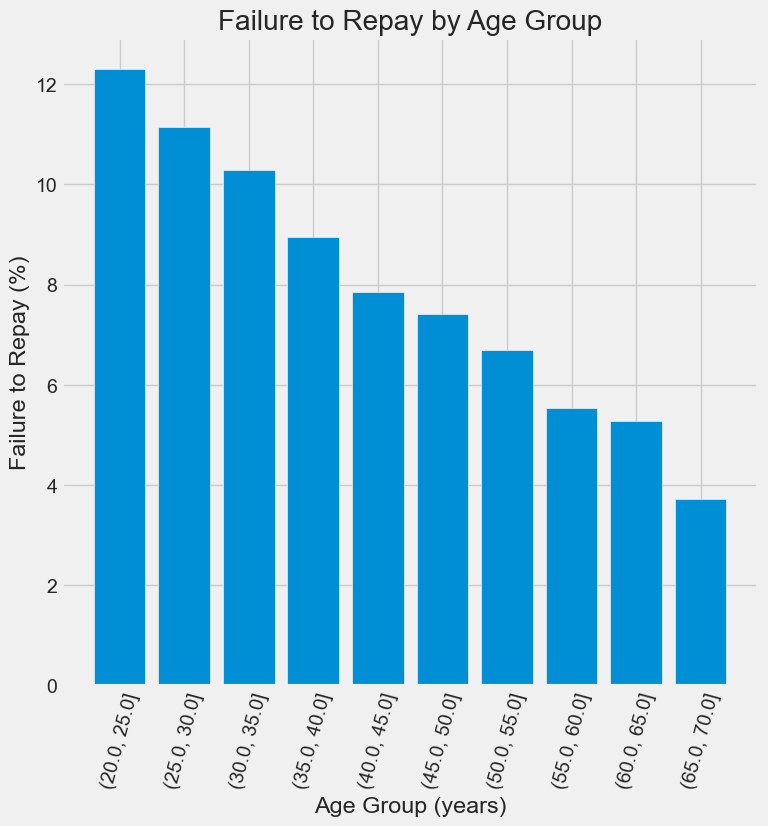

In [35]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

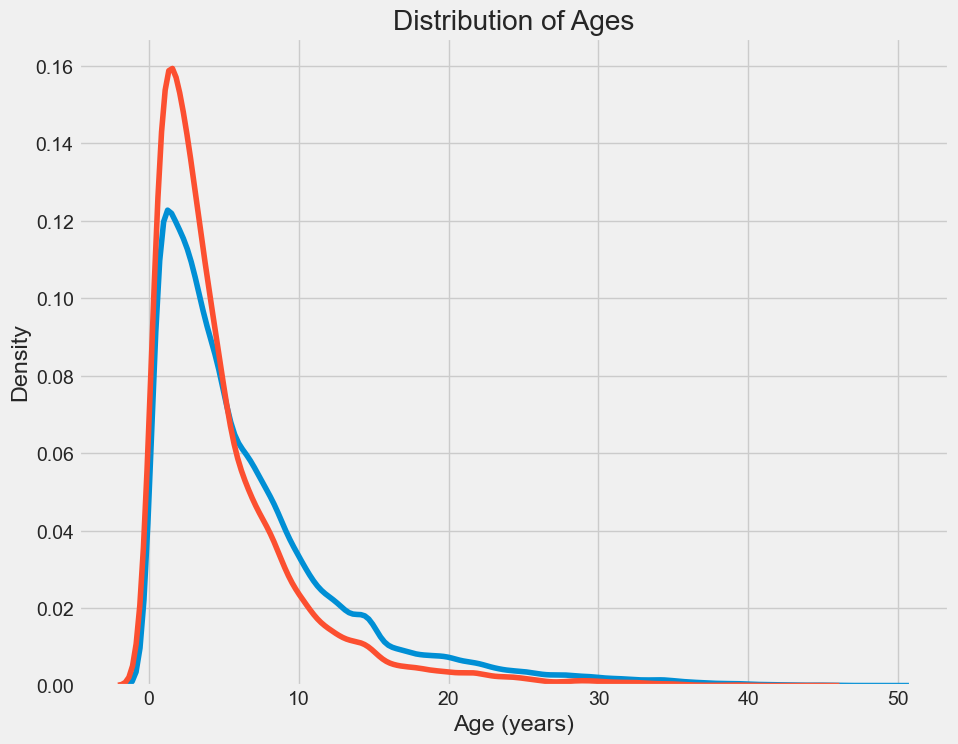

In [88]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Ages');

In [90]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
TARGET         1.000000     -0.155317     -0.160472     -0.178919   
EXT_SOURCE_1  -0.155317      1.000000      0.213982      0.186846   
EXT_SOURCE_2  -0.160472      0.213982      1.000000      0.109167   
EXT_SOURCE_3  -0.178919      0.186846      0.109167      1.000000   
DAYS_EMPLOYED -0.074958      0.252712      0.093444      0.129722   

               DAYS_EMPLOYED  
TARGET             -0.074958  
EXT_SOURCE_1        0.252712  
EXT_SOURCE_2        0.093444  
EXT_SOURCE_3        0.129722  
DAYS_EMPLOYED       1.000000

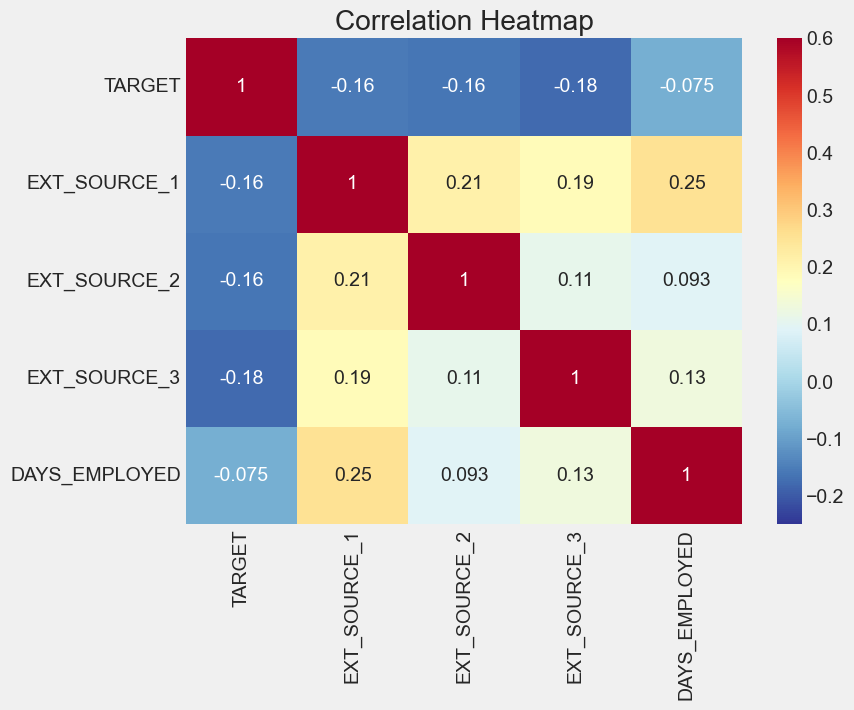

In [91]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

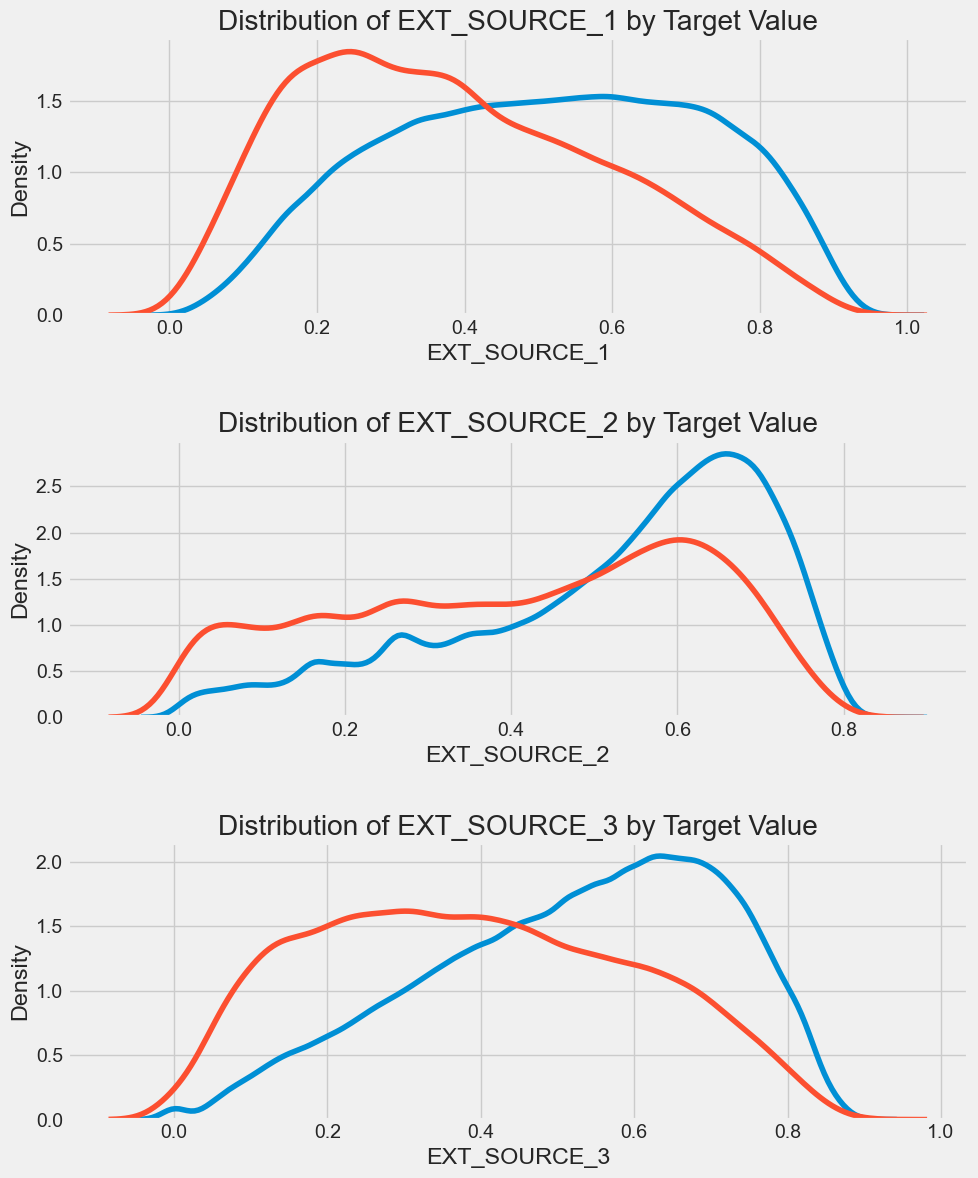

In [92]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/distributions.py:1138: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/distributions.py:1138: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/distributions.py:1138: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/distributions.py:1138: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/distributions.py:1138: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sea

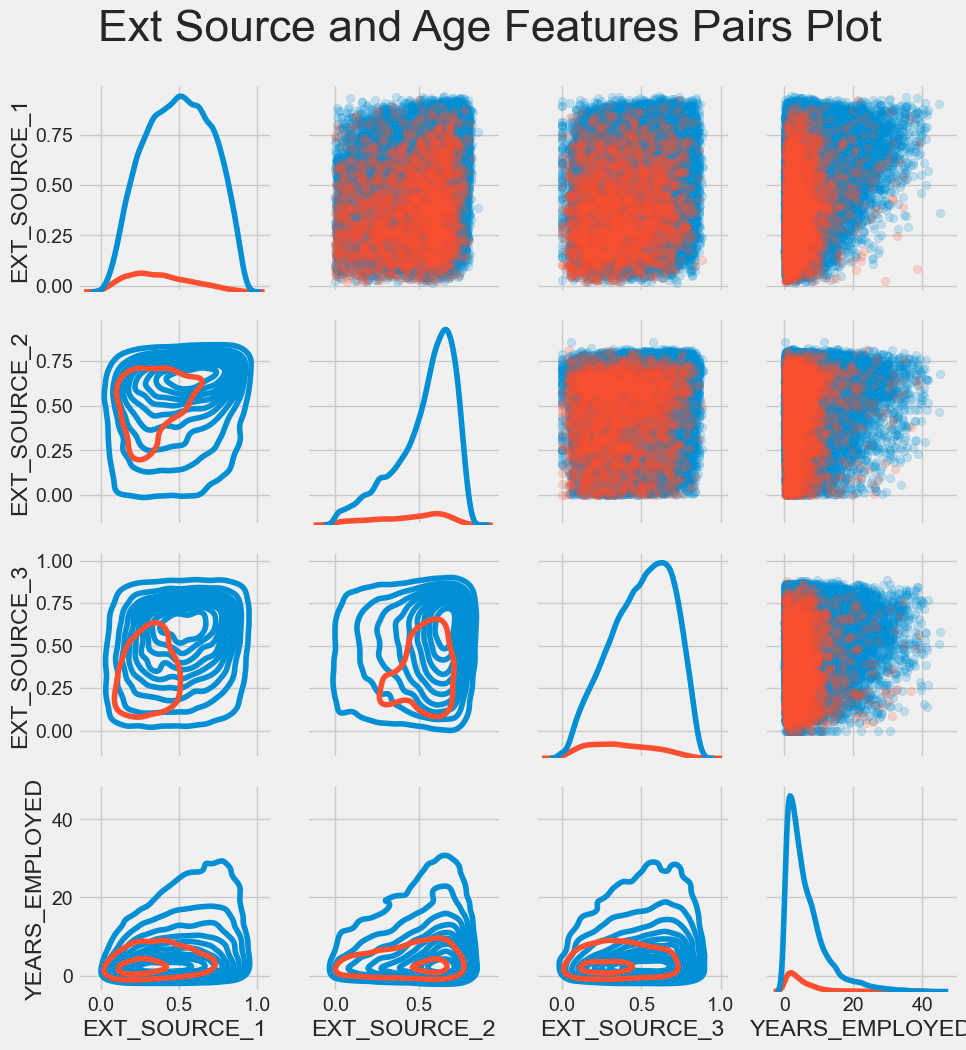

In [96]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_EMPLOYED']).copy()

# Add in the age of the client in years
plot_data['YEARS_EMPLOYED'] = age_data['YEARS_EMPLOYED']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);